In [1]:
%run ./utils.ipynb

In [2]:
train_df = pd.read_csv('../output/train_df.csv')
train_df.head()

,ImageId,EP1,EP2,EP3,EP4
0,706efa6c9.jpg,NaN,NaN,NaN,NaN
1,c4260033a.jpg,NaN,NaN,NaN,NaN
2,94a5728a6.jpg,NaN,NaN,NaN,NaN
3,8f3044c4f.jpg,NaN,NaN,244994 95 245250 190 245506 189 245762 188 246...,NaN
4,f74f33985.jpg,NaN,NaN,46680 8 46928 18 47181 23 47434 27 47686 33 47...,NaN


------------------------

**Load data:**
-------------------
* helper methods
* create dataset
* visualize example images

In [3]:
classes = []
for i, row in train_df.iterrows():
    tmp_classes = np.zeros(4)
    if type(row['EP1']) != float:
        tmp_classes[0] = 1
    if type(row['EP2']) != float:
        tmp_classes[1] = 1
    if type(row['EP3']) != float:
        tmp_classes[2] = 1
    if type(row['EP4']) != float:
        tmp_classes[3] = 1
    classes.append(tmp_classes)

train_df['class'] = classes
print(train_df.shape)
train_df.head()

(12568, 6)


,ImageId,EP1,EP2,EP3,EP4,class
0,706efa6c9.jpg,NaN,NaN,NaN,NaN,"[0.0, 0.0, 0.0, 0.0]"
1,c4260033a.jpg,NaN,NaN,NaN,NaN,"[0.0, 0.0, 0.0, 0.0]"
2,94a5728a6.jpg,NaN,NaN,NaN,NaN,"[0.0, 0.0, 0.0, 0.0]"
3,8f3044c4f.jpg,NaN,NaN,244994 95 245250 190 245506 189 245762 188 246...,NaN,"[0.0, 0.0, 1.0, 0.0]"
4,f74f33985.jpg,NaN,NaN,46680 8 46928 18 47181 23 47434 27 47686 33 47...,NaN,"[0.0, 0.0, 1.0, 0.0]"


In [4]:
X = np.array(train_df['ImageId'].values.tolist())
y = np.array(train_df['class'].values.tolist())

mskf = MultilabelStratifiedShuffleSplit(n_splits=2, test_size=0.15)

for train_index, test_index in mskf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [    0     1     2 ... 12565 12566 12567] TEST: [    6     7    13 ... 12544 12548 12549]
TRAIN: [    0     1     2 ... 12565 12566 12567] TEST: [    5    11    14 ... 12510 12527 12558]


In [5]:
y_train_count = np.sum(y_train, axis=0)
y_test_count = np.sum(y_test, axis=0)
y_train_neg = len(y_train.flatten())-np.count_nonzero(y_train.flatten())
y_test_neg = len(y_test.flatten())-np.count_nonzero(y_test.flatten())

In [6]:
class SteelDataset(Dataset):
    def __init__(self, df, x_col, y_col, path):
        self.df = df
        self.x_col = x_col
        self.y_col = y_col
        self.path = path
        self.mean = np.array([0.485, 0.456, 0.406])
        self.std = np.array([0.229, 0.224, 0.225])
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # load image
        im_name = self.df[self.x_col].iloc[idx]
        img_path = f"{self.path}/{im_name}"
        img = cv2.imread(img_path)
        
        # normalize image
        img = img.astype(np.float32) / 255.0
        img = img - self.mean
        img = img / self.std
        
        img = cv2.resize(img, dsize=(800,128), interpolation=cv2.INTER_LINEAR)
        
        # augment image and mask
        hflip = random.random() < 0.5
        if hflip:
            img = np.fliplr(img).copy()
            
        vflip = random.random() < 0.5
        if vflip:
            img = np.flipud(img).copy()
            
        # convert to torch tensors
        img = torch.from_numpy(img)
        img = img.permute(2, 0, 1)
        
        #combine
        sample = {'image': img, 'classes': self.df[self.y_col].iloc[idx]}
        return sample

In [7]:
steel_dataset = SteelDataset(train_df, 'ImageId', 'class', train_path)

/opt/conda/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


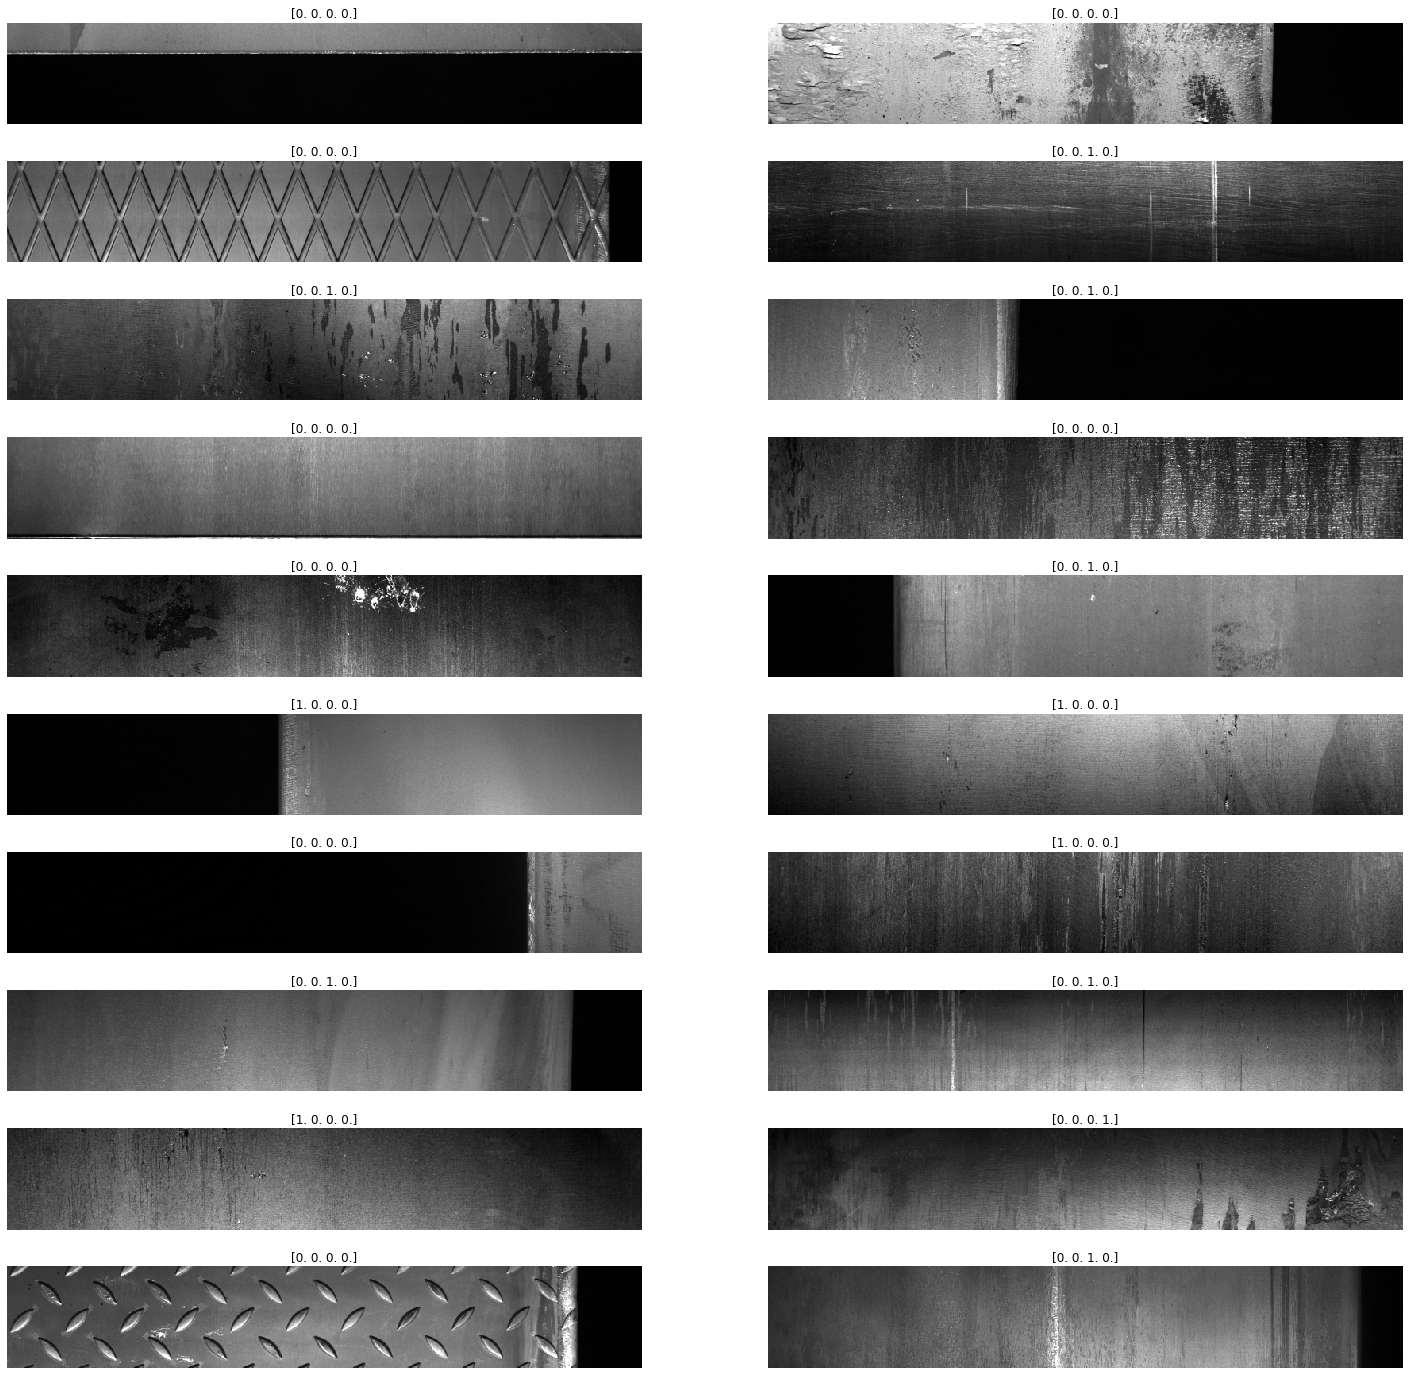

In [8]:
inc = 0
j = 0
fig, axs = plt.subplots(nrows=10, ncols=2, figsize=(25, 25), sharex=True)
for i in range(0,20,2):
    item1 = steel_dataset.__getitem__(i+inc)
    item2 = steel_dataset.__getitem__(i+inc+1)
    axs[j,0].set_title(item1['classes'])
    axs[j,0].imshow(item1['image'].permute(1, 2, 0)[:,:,0], cmap='gray')
    axs[j,0].axis('off')
    axs[j,1].set_title(item2['classes'])
    axs[j,1].imshow(item2['image'].permute(1, 2, 0)[:,:,0], cmap='gray')
    axs[j,1].axis('off')
    j+=1

In [9]:
# Parameters
params_train = {'batch_size': 8,
          'num_workers': 6}

params_val = {'batch_size': 8,
          'shuffle': False,
          'num_workers': 6}

train_dataset = SteelDataset(train_df.iloc[train_index], 'ImageId', 'class', train_path)
training_generator = DataLoader(train_dataset, pin_memory  = True, **params_train)

val_dataset = SteelDataset(train_df.iloc[test_index], 'ImageId', 'class', train_path)
validation_generator = DataLoader(val_dataset, pin_memory  = True, **params_val)

--------------------------

In [10]:
x = torch.Tensor([[1,1,1,1,0],[1,1,1,1,0],[1,1,1,1,0],[1,1,1,1,0],[1,1,1,1,0],[1,0,1,1,0]])
y = torch.Tensor([[1,1,1,1,1],[1,1,1,1,0],[1,1,1,1,0],[1,1,1,1,0],[1,1,1,1,0],[1,1,1,1,0]])

In [11]:
# Metric
def metric_hit(logit, truth, threshold=0.5):
    batch_size,num_class = logit.shape

    with torch.no_grad():
        logit = logit.view(batch_size,num_class,-1)
        truth = truth.view(batch_size,num_class,-1)

        probability = torch.sigmoid(logit)
        p = (probability>threshold).float()
        t = (truth>0.5).float()

        tp = ((p + t) == 2).float()  # True positives
        tn = ((p + t) == 0).float()  # True negatives

        tp = tp.sum(dim=[0,2])
        tn = tn.sum(dim=[0,2])
        num_pos = t.sum(dim=[0,2])
        num_neg = batch_size - num_pos

        tp_num = tp.data.cpu().numpy()
        tn_num = tn.data.cpu().numpy().sum()
        num_pos = num_pos.data.cpu().numpy()
        num_neg = num_neg.data.cpu().numpy().sum()

        tp = np.nan_to_num(tp_num/(num_pos+1e-12),0)
        tn = np.nan_to_num(tn_num/(num_neg+1e-12),0)

        tp = list(tp)
        num_pos = list(num_pos)

    return tn,tp,tn_num,tp_num

In [12]:
metric_hit(x,y)

(0.9999999999997999,
 [1.0, 0.8333333, 1.0, 1.0, 0.0],
 5.0,
 array([6., 5., 6., 6., 0.], dtype=float32))

**Metrics:**
------------

In [13]:
def criterion(logit, truth, class_weight=[3,1,18,3], weight=None):
    logit = logit.view(-1)
    truth = truth.view(-1)
    loss = F.binary_cross_entropy_with_logits(logit, truth, reduction='none')

    if weight is None:
        loss = loss.mean()

    else:
        class_weight = class_weight/np.mean(class_weight)
        weight = weight/np.mean(weight)
        loss = loss*torch.Tensor(class_weight).cuda()
        pos = (truth>0.5).float() #[1,0,0,0,1,...]
        neg = (truth<0.5).float() #[0,1,1,1,0,...]
        pos_sum = pos.sum().item() + 1e-12 #2
        neg_sum = neg.sum().item() + 1e-12 #3
        loss = (weight[1]*pos*loss/pos_sum + weight[0]*neg*loss/neg_sum).mean()
        #raise NotImplementedError

    return loss

--------------------

**Create model:**
-------------------

In [14]:
class Mish(nn.Module):
    def __init__(self):
        super().__init__()
        #print("Mish activation loaded...")

    def forward(self, x): 
        
        x = x *( torch.tanh(F.softplus(x)))

        return x

**Train:**
--------------

In [15]:
cudnn.benchmark = True

max_epochs = 50
base_lr = 0.00001

model = EfficientNet.from_pretrained('efficientnet-b3', num_classes=4) 
model._swish = Mish()

# group weight and config optimizer
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=base_lr, momentum=0.9, weight_decay=0.0001)
    
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

model.to(device)

Loaded pretrained weights for efficientnet-b3


In [16]:
def save_checkpoint(state, is_best, filename='../output/models/efficentnet_model1.pth'):
    # taken from https://blog.floydhub.com/checkpointing-tutorial-for-tensorflow-keras-and-pytorch/
    """Save checkpoint if a new best is achieved"""
    if is_best:
        print ("=> Saving a new best")
        torch.save(state, filename)  # save checkpoint
    else:
        print('\n')

In [17]:
def time_to_str(t, mode='min'):
    if mode=='min':
        t  = int(t)/60
        hr = t//60
        min = t%60
        return '%2d hr %02d min'%(hr,min)

    elif mode=='sec':
        t   = int(t)
        min = t//60
        sec = t%60
        return '%2d min %02d sec'%(min,sec)

    else:
        raise NotImplementedError

In [19]:
print('rate     batch    epoch |  loss    tn, [tp1,tp2,tp3,tp4]       |  loss    tn, [tp1,tp2,tp3,tp4]       | time           ')
print('--------------------------------------------------------------------------------------------------------------------\n')
best_loss_set = False
start = timer()
model.train()
for epoch in range(max_epochs):
    running_loss_train = 0
    running_tn = 0
    running_tp = np.zeros(4)
    rate = get_lr(optimizer)
    
    for idx, minibatch in enumerate(training_generator):
        optimizer.zero_grad()

        imgs = minibatch['image'].float()
        labels = minibatch['classes']

        imgs = imgs.cuda()
        labels = labels.cuda()
        
        logits = model.forward(imgs)
        
        #print((labels, logits))
        loss = criterion(logits, labels)
        tn, tp, num_neg, num_pos = metric_hit(logits, labels)
        
        running_loss_train += loss
        running_tn += num_neg
        running_tp = np.add(num_pos,running_tp)
        
        loss.backward()
        optimizer.step()
        
        print('\r',end='',flush=True)
        asterisk = ' '
        print('%0.5f  %5.1f%s %5.1f |  %5.3f   %4.2f [%4.2f,%4.2f,%4.2f,%4.2f]  | %s' % (\
                     rate, idx/len(training_generator), asterisk, epoch,
                     loss, tn, *tp[:6],
                     time_to_str((timer() - start),'min'))
        , end='',flush=True)
  
    with torch.set_grad_enabled(False):
        running_loss_val = 0
        running_tn_val = 0
        running_tp_val = np.zeros(4)
        
        loss_train = running_loss_train/len(training_generator)
        tn_train = running_tn/y_train_neg
        tp_train = np.divide(running_tp, y_train_count)
        
        for idx, minibatch in enumerate(validation_generator):
            imgs = minibatch['image'].float()
            labels = minibatch['classes']

            imgs = imgs.cuda()
            labels = labels.cuda()

        
            logits = model.forward(imgs)

            loss = criterion(logits, labels)
            tn, tp, num_neg, num_pos = metric_hit(logits, labels)

            running_loss_val += loss
            running_tn_val += num_neg
            running_tp_val = np.add(num_pos,running_tp_val)
            
            print('\r',end='',flush=True)
            asterisk = ' '
            print('%0.5f  %5.1f%s %5.1f |  %5.3f   %4.2f [%4.2f,%4.2f,%4.2f,%4.2f]  |  %5.3f   %4.2f [%4.2f,%4.2f,%4.2f,%4.2f]  | %s' % (\
                     rate, idx/len(validation_generator), asterisk, epoch,
                     loss_train, tn_train, *tp_train[:6],
                     loss, tn, *tp[:6],                                                                                                         
                     time_to_str((timer() - start),'min'))
            , end='',flush=True)


        val_loss = running_loss_val/len(validation_generator)
        tn_val = running_tn_val/y_test_neg
        tp_val = np.divide(running_tp_val, y_test_count)
            

        print('\r',end='',flush=True)
        asterisk = ' '
        print('%0.5f  %5.1f%s %5.1f |  %5.3f   %4.2f [%4.2f,%4.2f,%4.2f,%4.2f]  |  %5.3f   %4.2f [%4.2f,%4.2f,%4.2f,%4.2f]  | %s' % (\
                 rate, idx/len(validation_generator), asterisk, epoch,
                 loss_train, tn_train, *tp_train[:6],
                 val_loss, tn_val, *tp_val[:6],                                                                                                         
                 time_to_str((timer() - start),'min'))
        )
                
        # Save checkpoint if is a new best
        if best_loss_set:
            is_best = bool(best_loss > val_loss)
            best_loss = min(val_loss, best_loss)
            save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_loss': best_loss
            }, is_best)
        else:
            best_loss = val_loss
            save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_loss': best_loss
            }, True)
            best_loss_set = True

        # Reduce LR on Plateau
        scheduler.step(loss)

rate     batch    epoch |  loss    tn, [tp1,tp2,tp3,tp4]       |  loss    tn, [tp1,tp2,tp3,tp4]       | time           
--------------------------------------------------------------------------------------------------------------------

0.00001    1.0    0.0 |  0.094   0.97 [0.92,0.86,0.98,0.94]  |  0.091   0.97 [0.91,0.89,0.99,0.96]  |  0 hr 05 min
=> Saving a new best
0.00001    1.0    1.0 |  0.089   0.97 [0.93,0.81,0.98,0.93]  |  0.086   0.97 [0.89,0.89,0.98,0.94]  |  0 hr 11 min
=> Saving a new best
0.00001    1.0    2.0 |  0.086   0.97 [0.91,0.81,0.98,0.93]  |  0.082   0.97 [0.90,0.84,0.98,0.92]  |  0 hr 17 min
=> Saving a new best
0.00001    1.0    3.0 |  0.079   0.98 [0.91,0.84,0.97,0.93]  |  0.078   0.98 [0.90,0.89,0.98,0.95]  |  0 hr 22 min
=> Saving a new best
0.00001    0.6    4.0 |  0.032   0.96 [0.00,0.00,1.00,0.00]  |  0 hr 26 min

KeyboardInterrupt: 

In [18]:
ckpt_path = "../output/models/working/00037500_model.pth"
state = torch.load(ckpt_path, map_location=lambda storage, loc: storage)
for k in ['logit.weight','logit.bias']:
    state.pop(k, None)
model.load_state_dict(state,strict=False)
model._swish = Mish()
model.to(device)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        40, 10, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        10, 40, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        40, 24, kernel_siz

In [ ]:
preds = []
trues = []
model.eval()
with torch.set_grad_enabled(False):
    for idx, minibatch in enumerate(tqdm(validation_generator)):
        imgs = minibatch['image'].float()
        labels = minibatch['classes']

        imgs = imgs.cuda()
        labels = labels.cuda()

        logits = model.forward(imgs, extract_feature = False)

        outputs = torch.argmax(logits,1)

        for i, output in enumerate(outputs):
            preds.append(output.data.to('cpu').numpy())
            trues.append(labels[i].data.to('cpu').numpy())

In [ ]:
train['class_single'].hist()

In [ ]:
confusion_matrix(np.array(preds), np.array(trues))